In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import tensorflow 
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from pandas import concat
from keras.models import Sequential
from keras.layers import LSTM, Dense
from cond_rnn import ConditionalRNN
import tensorflow as tf
from numpy import asarray
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_error
import time


Using TensorFlow backend.


In [2]:
gateway = pd.read_csv('C:/Users/wanru/OneDrive - Ecolab/Desktop/tlm_analysis/data/processed/07-08-20-gateway-subset.csv')
controller = pd.read_csv('C:/Users/wanru/OneDrive - Ecolab/Desktop/tlm_analysis/data/processed/07-08-20-controller-subset.csv')
facility = pd.read_csv('C:/Users/wanru/OneDrive - Ecolab/Desktop/tlm_analysis/data/processed/07-08-20-facility-subset.csv')


In [3]:
import copy
def _read_measurement_data(fpath):
    ddf = pd.read_csv(fpath)
    df = ddf.pivot(index="MeasurementDate", columns="TankID")
    df.columns = [x[1] for x in df.columns.values]
    df.index = df.index.astype("M8[ns]")
    return df.fillna(0)
def _transform_data(df_resampled: pd.DataFrame):
    """ Resamples the historical data for the tanks being modeled """
    df_differences = copy.copy(df_resampled.diff().fillna(0))
    df_differences[df_differences > 0.5] = 0
    return df_differences

In [4]:
controller_path='C:/Users/wanru/OneDrive - Ecolab/Desktop/tlm_analysis/data/processed/07-08-20-controller-subset.csv'
gateway_path = 'C:/Users/wanru/OneDrive - Ecolab/Desktop/tlm_analysis/data/processed/07-08-20-gateway-subset.csv'
CT = _read_measurement_data(controller_path)
GT = _read_measurement_data(gateway_path)    
CT_tank_ids = CT.columns
CT_resampled = CT.resample("D").mean().interpolate()
CT_features = _transform_data(CT_resampled)

GT_tank_ids = GT.columns
GT_resampled = GT.resample("D").mean().interpolate()
GT_features = _transform_data(GT_resampled)

In [5]:
def process_single_tank(series,window_size,scaler):
    #normalizing the data using minmax scaler
    scaled = scaler.fit_transform(series)
    series = pd.DataFrame(scaled) 
    #series = pd.DataFrame(series)
    series_s = series.copy()
    for i in range(window_size):
        series = pd.concat([series,series_s.shift(-(i+1))],axis =1)    
    series.dropna(axis=0,inplace=True)
    nrow = round(series.shape[0]-42)
    train = series.iloc[:nrow, :]
    test = series.iloc[nrow:,:]
    from sklearn.utils import shuffle
    train = shuffle(train)

    train_X = train.iloc[:,:-1]
    train_y = train.iloc[:,-1]
    test_X = test.iloc[:,:-1]
    test_y = test.iloc[:,-1]
    train_X = train_X.values
    train_y = train_y.to_numpy().reshape(-1,1)
    test_X = test_X.values
    test_y = test_y.to_numpy().reshape(-1,1)


    
    return train_X,train_y,test_X,test_y,nrow


In [6]:
def process_all_tank(CT_features,window_size):
    #scaler = MinMaxScaler(feature_range=(-1,1))
    scaler = RobustScaler()
    train_X_all = None
    # iterate by TankID in Controller features
    for column_name in CT_features: 
        series = CT_features[column_name].to_numpy().reshape(-1,1)
        train_X,train_y,test_X,test_y,nrow = process_single_tank(series,window_size,scaler)
        train_X = train_X.reshape(train_X.shape[0],train_X.shape[1],1)
        test_X = test_X.reshape(test_X.shape[0],test_X.shape[1],1)
        
        if train_X_all is None:
            train_X_all = train_X
#            train_y_all = train_y
            test_X_all = test_X
 #           test_y_all = test_y
        else:
            train_X_all = np.concatenate([train_X_all, train_X], -1)
            test_X_all = np.concatenate([test_X_all, test_X], -1)
#            train_y_all = np.concatenate([train_y_all, train_y], -1)
#            test_y_all = np.concatenate([test_y_all, test_y], -1)
    train_y_all = CT_features.iloc[window_size:nrow+window_size,]
    test_y_all = CT_features.iloc[nrow+window_size:,]
    return train_X_all,test_X_all,train_y_all,test_y_all,nrow

In [8]:
def process_all_tank_with_facility(CT_features,facility,window_size):
    #scaler = MinMaxScaler(feature_range=(-1,1))
    scaler = RobustScaler()
#    scaler_ordervolume = MinMaxScaler(feature_range=(-1,1))  
#    scaler_tankorder = MinMaxScaler(feature_range=(-1,1))  
#    scaler_tankvolume = MinMaxScaler(feature_range=(-1,1))
    facility['OrderVolume'] = pd.DataFrame(scaler.fit_transform(pd.DataFrame(facility['OrderVolume'])),columns=['OrderVolume'] )
    facility['TankOrder'] = pd.DataFrame(scaler.fit_transform(pd.DataFrame(facility['TankOrder'])),columns=['TankOrder'] )
    facility['TankVolume'] = pd.DataFrame(scaler.fit_transform(pd.DataFrame(facility['TankVolume'])),columns=['TankVolume'])
    #df[col] = pd.DataFrame(min_max_scaler.fit_transform(pd.DataFrame(dfTest[col])),columns=[col])    
    train_X_all = None
    # iterate by TankID in Controller features
    for column_name in CT_features: 
        series = CT_features[column_name].to_numpy().reshape(-1,1)
        train_X,train_y,test_X,test_y,nrow = process_single_tank(series,window_size,scaler)
        #order_volume, tank_order, tank_volume : most important facility features       
        order_volume = facility[facility['TankID']==column_name]['OrderVolume']
        tank_order = facility[facility['TankID']==column_name]['TankOrder']        
        tank_volume = facility[facility['TankID']==column_name]['TankVolume']
         
        order_volume_train = np.array([order_volume.values] * nrow)        
        order_volume_test = np.array([order_volume.values] * 42)   
        
        tank_order_train = np.array([tank_order.values] * nrow)        
        tank_order_test = np.array([tank_order.values] * 42)   
        
        tank_volume_train = np.array([tank_volume.values] * nrow)        
        tank_volume_test = np.array([tank_volume.values] * 42)   
        
        train_X = np.append( order_volume_train, train_X,axis=1)
        test_X = np.append( order_volume_test, test_X, axis=1)
        
        train_X = np.append(tank_order_train,train_X,  axis=1)
        test_X = np.append(tank_order_test,test_X,  axis=1) 
        
        train_X = np.append(tank_volume_train,train_X, axis=1)
        test_X = np.append(tank_volume_test,test_X, axis=1)        
        
        train_X = train_X.reshape(train_X.shape[0],train_X.shape[1],1)
        test_X = test_X.reshape(test_X.shape[0],test_X.shape[1],1)
        if train_X_all is None:
            train_X_all = train_X
            train_y_all = train_y
            test_X_all = test_X
            test_y_all = test_y
        else:
            train_X_all = np.concatenate([train_X_all, train_X], -1)
            test_X_all = np.concatenate([test_X_all, test_X], -1)
            train_y_all = np.concatenate([train_y_all, train_y], -1)
            test_y_all = np.concatenate([test_y_all, test_y], -1)
    train_y_all = CT_features.iloc[window_size:nrow+window_size,]
    test_y_all = CT_features.iloc[nrow+window_size:,]
    return train_X_all,test_X_all,train_y_all,test_y_all,nrow

In [120]:
window_size = 21
train_X_21_facility,test_X_21_facility,train_y_21_facility,test_y_21_facility,nrow = process_all_tank_with_facility(CT_features,facility,window_size)

In [7]:
window_size = 50
train_X_all_50,test_X_all_50,train_y_all_50,test_y_all_50,nrow = process_all_tank(CT_features,window_size)

In [8]:
window_size = 30
train_X_all_30,test_X_all_30,train_y_all_30,test_y_all_30,nrow = process_all_tank(CT_features,window_size)

In [9]:
window_size = 21
train_X_all_21,test_X_all_21,train_y_all_21,test_y_all_21,nrow = process_all_tank(CT_features,window_size)

In [10]:
window_size = 14
train_X_all_14,test_X_all_14,train_y_all_14,test_y_all_14,nrow = process_all_tank(CT_features,window_size)

In [11]:
print(train_X_all_21.shape)
print(test_X_all_21.shape)
print(train_y_all_21.shape)
print(test_y_all_21.shape)
print(CT_features.shape)

(694, 21, 93)
(42, 21, 93)
(694, 93)
(42, 93)
(757, 93)


In [62]:
print(train_X_21_facility.shape)
print(test_X_21_facility.shape)
print(train_y_21_facility.shape)
print(test_y_21_facility.shape)
print(CT_features.shape)

(694, 24, 93)
(42, 24, 93)
(694, 93)
(42, 93)
(757, 93)


**one epoch** = one forward pass and one backward pass of all the training examples<br>
**batch size** = the number of training examples in one forward/backward pass. The higher the batch size, the more memory space you'll need.<br>
**number of iterations** = number of passes, each pass using [batch size] number of examples. To be clear, one pass = one forward pass + one backward pass (we do not count the forward pass and backward pass as two different passes).<br>
**Example**: if you have 1000 training examples, and your batch size is 500, then it will take 2 iterations to complete 1 epoch.<br>

In [12]:
opt = Adam(lr=0.001, clipnorm=1.0)# gradient clipping to avoid exploding gradients
model_scaled = Sequential()
model_scaled.add(LSTM(256, return_sequences = True, input_shape = (50, 93)))
model_scaled.add(Dropout(0.5))
model_scaled.add(LSTM(128,input_shape = (50, 93)))
model_scaled.add(Dense(93,kernel_regularizer='l2'))# add L2 norm to regularize data, another way to avoid exploding gradients
model_scaled.compile(loss = 'mean_absolute_error', optimizer = opt)
model_scaled.save_weights('LSTM_0.h5')
model_scaled.load_weights('LSTM_0.h5')
model_scaled_result_50 = model_scaled.fit(train_X_all_50, train_y_all_50, epochs = 40, batch_size = 20,validation_split=0.1)
model_scaled.save_weights('LSTM_window50.h5')
#model.load_weights('LSTMBasic1.h5')
# optimze num epoch. and moving window 


Train on 598 samples, validate on 67 samples
Epoch 1/40
598/598 [==============================] - 8s 14ms/step - loss: 1.9766 - val_loss: 1.8699
Epoch 2/40
598/598 [==============================] - 6s 10ms/step - loss: 1.5548 - val_loss: 1.5828
Epoch 3/40
598/598 [==============================] - 7s 11ms/step - loss: 1.3297 - val_loss: 1.4235
Epoch 4/40
598/598 [==============================] - 5s 9ms/step - loss: 1.2051 - val_loss: 1.3479
Epoch 5/40
598/598 [==============================] - 6s 10ms/step - loss: 1.1372 - val_loss: 1.3006
Epoch 6/40
598/598 [==============================] - 6s 9ms/step - loss: 1.1018 - val_loss: 1.2775
Epoch 7/40
598/598 [==============================] - 6s 10ms/step - loss: 1.0829 - val_loss: 1.2693
Epoch 8/40
598/598 [==============================] - 6s 9ms/step - loss: 1.0723 - val_loss: 1.2519
Epoch 9/40
598/598 [==============================] - 6s 10ms/step - loss: 1.0661 - val_loss: 1.2466
Epoch 10/40
598/598 [============================

In [13]:
opt = Adam(lr=0.001, clipnorm=1.0)# gradient clipping to avoid exploding gradients
model_scaled_30 = Sequential()
model_scaled_30.add(LSTM(256, return_sequences = True, input_shape = (30, 93)))
model_scaled_30.add(Dropout(0.5))
model_scaled_30.add(LSTM(128,input_shape = (30, 93)))
model_scaled_30.add(Dense(93,kernel_regularizer='l2'))# add L2 norm to regularize data, another way to avoid exploding gradients
model_scaled_30.compile(loss = 'mean_absolute_error', optimizer = opt)
model_scaled_result_30 = model_scaled_30.fit(train_X_all_30, train_y_all_30, epochs = 40, batch_size = 20,validation_split=0.1)
model_scaled_30.save_weights('LSTM_window30.h5')
#model_scaled_30.load_weights('LSTM_0.h5')


Train on 616 samples, validate on 69 samples
Epoch 1/40
616/616 [==============================] - 6s 9ms/step - loss: 1.9809 - val_loss: 1.8588
Epoch 2/40
616/616 [==============================] - 4s 6ms/step - loss: 1.5430 - val_loss: 1.5721
Epoch 3/40
616/616 [==============================] - 4s 6ms/step - loss: 1.3130 - val_loss: 1.4107
Epoch 4/40
616/616 [==============================] - 4s 7ms/step - loss: 1.1887 - val_loss: 1.3355
Epoch 5/40
616/616 [==============================] - 4s 6ms/step - loss: 1.1229 - val_loss: 1.2854
Epoch 6/40
616/616 [==============================] - 3s 6ms/step - loss: 1.0887 - val_loss: 1.2669
Epoch 7/40
616/616 [==============================] - 4s 6ms/step - loss: 1.0705 - val_loss: 1.2493
Epoch 8/40
616/616 [==============================] - 4s 6ms/step - loss: 1.0602 - val_loss: 1.2447
Epoch 9/40
616/616 [==============================] - 4s 6ms/step - loss: 1.0550 - val_loss: 1.2477
Epoch 10/40
616/616 [==============================] - 

In [14]:
start = time.time()
opt = Adam(lr=0.001, clipnorm=1.0)# gradient clipping to avoid exploding gradients
model_scaled_21 = Sequential()
model_scaled_21.add(LSTM(256, return_sequences = True, input_shape = (21, 93)))
model_scaled_21.add(Dropout(0.5))
model_scaled_21.add(LSTM(128,input_shape = (21, 93)))
model_scaled_21.add(Dense(93,kernel_regularizer='l2'))# add L2 norm to regularize data, another way to avoid exploding gradients
model_scaled_21.compile(loss = 'mean_absolute_error', optimizer = opt)
model_scaled_result_21 = model_scaled_21.fit(train_X_all_21, train_y_all_21, epochs = 40, batch_size = 20,validation_split=0.1)
model_scaled_21.save_weights('LSTM_window21.h5')
print("> Compilation Time : ", time.time() - start)

Train on 624 samples, validate on 70 samples
Epoch 1/40
624/624 [==============================] - 5s 8ms/step - loss: 1.9817 - val_loss: 1.8451
Epoch 2/40
624/624 [==============================] - 3s 5ms/step - loss: 1.5261 - val_loss: 1.5507
Epoch 3/40
624/624 [==============================] - 3s 5ms/step - loss: 1.2962 - val_loss: 1.3963
Epoch 4/40
624/624 [==============================] - 3s 5ms/step - loss: 1.1746 - val_loss: 1.3205
Epoch 5/40
624/624 [==============================] - 3s 5ms/step - loss: 1.1116 - val_loss: 1.2808
Epoch 6/40
624/624 [==============================] - 3s 5ms/step - loss: 1.0795 - val_loss: 1.2600
Epoch 7/40
624/624 [==============================] - 3s 5ms/step - loss: 1.0630 - val_loss: 1.2454
Epoch 8/40
624/624 [==============================] - 3s 4ms/step - loss: 1.0543 - val_loss: 1.2373
Epoch 9/40
624/624 [==============================] - 3s 5ms/step - loss: 1.0478 - val_loss: 1.2407
Epoch 10/40
624/624 [==============================] - 

In [15]:
opt = Adam(lr=0.001, clipnorm=1.0)# gradient clipping to avoid exploding gradients
model_scaled_14 = Sequential()
model_scaled_14.add(LSTM(256, return_sequences = True, input_shape = (14, 93)))
model_scaled_14.add(Dropout(0.5))
model_scaled_14.add(LSTM(128,input_shape = (14, 93)))
model_scaled_14.add(Dense(93,kernel_regularizer='l2'))# add L2 norm to regularize data, another way to avoid exploding gradients
model_scaled_14.compile(loss = 'mean_absolute_error', optimizer = opt)
model_scaled_result_14 = model_scaled_14.fit(train_X_all_14, train_y_all_14, epochs = 40, batch_size = 20,validation_split=0.1)
model_scaled_14.save_weights('LSTM_window14.h5')

Train on 630 samples, validate on 71 samples
Epoch 1/40
630/630 [==============================] - 3s 5ms/step - loss: 1.9602 - val_loss: 1.8591
Epoch 2/40
630/630 [==============================] - 2s 3ms/step - loss: 1.5120 - val_loss: 1.5699
Epoch 3/40
630/630 [==============================] - 2s 3ms/step - loss: 1.2855 - val_loss: 1.4138
Epoch 4/40
630/630 [==============================] - 2s 3ms/step - loss: 1.1676 - val_loss: 1.3346
Epoch 5/40
630/630 [==============================] - 2s 3ms/step - loss: 1.1054 - val_loss: 1.2946
Epoch 6/40
630/630 [==============================] - 2s 3ms/step - loss: 1.0736 - val_loss: 1.2801
Epoch 7/40
630/630 [==============================] - 2s 3ms/step - loss: 1.0573 - val_loss: 1.2622
Epoch 8/40
630/630 [==============================] - 2s 3ms/step - loss: 1.0479 - val_loss: 1.2504
Epoch 9/40
630/630 [==============================] - 2s 3ms/step - loss: 1.0432 - val_loss: 1.2524
Epoch 10/40
630/630 [==============================] - 

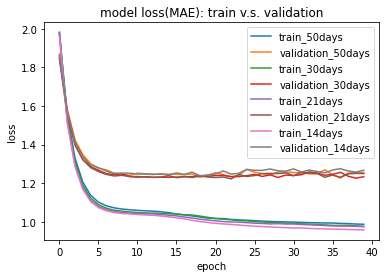

In [16]:
plt.plot(model_scaled_result_50.history['loss'])
plt.plot(model_scaled_result_50.history['val_loss'])
plt.plot(model_scaled_result_30.history['loss'])
plt.plot(model_scaled_result_30.history['val_loss'])
plt.plot(model_scaled_result_21.history['loss'])
plt.plot(model_scaled_result_21.history['val_loss'])
plt.plot(model_scaled_result_14.history['loss'])
plt.plot(model_scaled_result_14.history['val_loss'])
#plt.plot(model_scaled_result_21_final.history['loss'])
#plt.plot(model_scaled_result_21_final.history['val_loss'])
plt.title('model loss(MAE): train v.s. validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_50days', 'validation_50days','train_30days', 'validation_30days','train_21days','validation_21days','train_14days', 'validation_14days'], loc='upper right')
#,'train_final','validation_final'
plt.show()

The model is overfitting when the validation loss is increasing while the training loss is decreasing.<br>
And it's overfitting when moving window 14 days<br>

Dealing with such a Model:<br>

Data Preprocessing: Standardizing and Normalizing the data.<br>
Model compelxity: Check if the model is too complex. Add dropout, reduce number of layers or number of neurons in each layer.<br>
Learning Rate and Decay Rate: Reduce the learning rate, a good starting value is usually between 0.0005 to 0.001. Also consider a decay rate of 1e-6.<br>

**change the learning rate from 0.01 to 0.001 solved this issue**

Choose Epoch = 10, Given moving window 21 days

In [20]:
start = time.time()
opt = Adam(lr=0.001, clipnorm=1.0)# gradient clipping to avoid exploding gradients
model_scaled_21_10batch = Sequential()
model_scaled_21_10batch.add(LSTM(256, return_sequences = True, input_shape = (21, 93)))
model_scaled_21_10batch.add(Dropout(0.5))
model_scaled_21_10batch.add(LSTM(128,input_shape = (21, 93)))
model_scaled_21_10batch.add(Dense(93,kernel_regularizer='l2'))# add L2 norm to regularize data, another way to avoid exploding gradients
model_scaled_21_10batch.compile(loss = 'mean_absolute_error', optimizer = opt)
model_scaled_result_21_10batch = model_scaled_21_10batch.fit(train_X_all_21, train_y_all_21, epochs = 10, batch_size = 10,validation_split=0.1)
model_scaled_21_10batch.save_weights('LSTM_window21_10batch.h5')
print("> Compilation Time : ", time.time() - start)

Train on 624 samples, validate on 70 samples
Epoch 1/10
624/624 [==============================] - 6s 10ms/step - loss: 1.7572 - val_loss: 1.5595
Epoch 2/10
624/624 [==============================] - 5s 8ms/step - loss: 1.2467 - val_loss: 1.3262
Epoch 3/10
624/624 [==============================] - 5s 8ms/step - loss: 1.1043 - val_loss: 1.2620
Epoch 4/10
624/624 [==============================] - 5s 8ms/step - loss: 1.0633 - val_loss: 1.2502
Epoch 5/10
624/624 [==============================] - 5s 8ms/step - loss: 1.0506 - val_loss: 1.2370
Epoch 6/10
624/624 [==============================] - 5s 8ms/step - loss: 1.0457 - val_loss: 1.2356
Epoch 7/10
624/624 [==============================] - 5s 8ms/step - loss: 1.0427 - val_loss: 1.2272
Epoch 8/10
624/624 [==============================] - 5s 8ms/step - loss: 1.0404 - val_loss: 1.2314
Epoch 9/10
624/624 [==============================] - 5s 8ms/step - loss: 1.0390 - val_loss: 1.2308
Epoch 10/10
624/624 [==============================] -

In [25]:
start = time.time()
opt = Adam(lr=0.001, clipnorm=1.0)# gradient clipping to avoid exploding gradients
model_scaled_21_30batch = Sequential()
model_scaled_21_30batch.add(LSTM(256, return_sequences = True, input_shape = (21, 93)))
model_scaled_21_30batch.add(Dropout(0.5))
model_scaled_21_30batch.add(LSTM(128,input_shape = (21, 93)))
model_scaled_21_30batch.add(Dense(93,kernel_regularizer='l2'))# add L2 norm to regularize data, another way to avoid exploding gradients
model_scaled_21_30batch.compile(loss = 'mean_absolute_error', optimizer = opt)
model_scaled_result_21_30batch = model_scaled_21_30batch.fit(train_X_all_21, train_y_all_21, epochs = 10, batch_size = 30,validation_split=0.1)
model_scaled_21_30batch.save_weights('LSTM_window21_30batch.h5')
print("> Compilation Time : ", time.time() - start)

Train on 624 samples, validate on 70 samples
Epoch 1/10
624/624 [==============================] - 4s 6ms/step - loss: 2.0630 - val_loss: 1.9876
Epoch 2/10
624/624 [==============================] - 2s 4ms/step - loss: 1.6953 - val_loss: 1.7280
Epoch 3/10
624/624 [==============================] - 2s 4ms/step - loss: 1.4695 - val_loss: 1.5544
Epoch 4/10
624/624 [==============================] - 2s 4ms/step - loss: 1.3211 - val_loss: 1.4405
Epoch 5/10
624/624 [==============================] - 2s 4ms/step - loss: 1.2233 - val_loss: 1.3647
Epoch 6/10
624/624 [==============================] - 2s 4ms/step - loss: 1.1591 - val_loss: 1.3194
Epoch 7/10
624/624 [==============================] - 3s 4ms/step - loss: 1.1173 - val_loss: 1.2885
Epoch 8/10
624/624 [==============================] - 2s 4ms/step - loss: 1.0901 - val_loss: 1.2710
Epoch 9/10
624/624 [==============================] - 2s 4ms/step - loss: 1.0731 - val_loss: 1.2622
Epoch 10/10
624/624 [==============================] - 

NameError: name 'model_scaled_result_21_10batch' is not defined

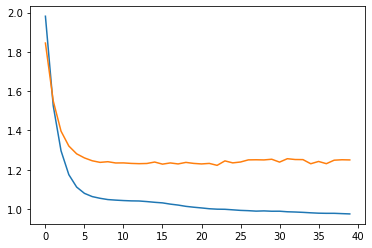

In [18]:
plt.plot(model_scaled_result_21.history['loss'])
plt.plot(model_scaled_result_21.history['val_loss'])
plt.plot(model_scaled_result_21_10batch.history['loss'])
plt.plot(model_scaled_result_21_10batch.history['val_loss'])
plt.title('model train v.s. loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_21days','validation_21days','train_final_smallerbatch','validation_final_smallerbatch'], loc='upper right')

plt.show()

In [ ]:
plt.plot(model_scaled_result_21.history['loss'])
plt.plot(model_scaled_result_21.history['val_loss'])
plt.plot(model_scaled_result_21_30batch.history['loss'])
plt.plot(model_scaled_result_21_30batch.history['val_loss'])
plt.title('model train v.s. loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_21days','validation_21days','train_final_largerbatch','validation_final_largerbatch'], loc='upper right')

plt.show()

With epoch = 10, moving window 21 days, smaller batch loss falls earlier but take more time to run.<br>
55s for 10 batch model; 34s for 20 batch to run; 29s for 30 batch to run. 

In [121]:
# epoch = 10, moving window 21 days, batch = 30 
# training with facility features
start = time.time()
opt = Adam(lr=0.001, clipnorm=1.0)# gradient clipping to avoid exploding gradients
model_facility = Sequential()
model_facility.add(LSTM(256, return_sequences = True, input_shape = (24, 93)))
model_facility.add(Dropout(0.5))
model_facility.add(LSTM(128,input_shape = (24, 93)))
model_facility.add(Dense(93,kernel_regularizer='l2'))# add L2 norm to regularize data, another way to avoid exploding gradients
model_facility.compile(loss = 'mean_absolute_error', optimizer = opt)
model_facility_result = model_facility.fit(train_X_21_facility, train_y_21_facility, epochs = 10, batch_size = 30,validation_split=0.1)
model_facility.save_weights('LSTM_with_facility.h5')
print("> Compilation Time : ", time.time() - start)

Train on 624 samples, validate on 70 samples
Epoch 1/10
624/624 [==============================] - 4s 7ms/step - loss: nan - val_loss: nan
Epoch 2/10
624/624 [==============================] - 3s 4ms/step - loss: nan - val_loss: nan
Epoch 3/10
624/624 [==============================] - 3s 5ms/step - loss: nan - val_loss: nan
Epoch 4/10
624/624 [==============================] - 3s 5ms/step - loss: nan - val_loss: nan
Epoch 5/10
624/624 [==============================] - 3s 4ms/step - loss: nan - val_loss: nan
Epoch 6/10
624/624 [==============================] - 3s 4ms/step - loss: nan - val_loss: nan
Epoch 7/10
624/624 [==============================] - 3s 4ms/step - loss: nan - val_loss: nan
Epoch 8/10
624/624 [==============================] - 3s 4ms/step - loss: nan - val_loss: nan
Epoch 9/10
624/624 [==============================] - 3s 4ms/step - loss: nan - val_loss: nan
Epoch 10/10
624/624 [==============================] - 3s 4ms/step - loss: nan - val_loss: nan
> Compilation 

In [26]:
# Doing a prediction on all the test data at once
preds = model_scaled_21_30batch.predict(test_X_all_21)
#preds = scaler.inverse_transform(preds)
actuals = test_y_all_21
#for i in range(preds.shape[1]): 
#    preds_single = scaler.inverse_transform(preds[:,i].reshape(1, -1))
#    preds[:,i] = preds_single
#    actuals_single = scaler.inverse_transform(test_y_all[:,i].reshape(1, -1))
#    actuals[:,i] = actuals_single
#actuals = test_y
preds.shape

(42, 93)

In [27]:
def moving_test_window_preds(n_future_preds):

    ''' n_future_preds - Represents the number of future predictions we want to make
                         This coincides with the number of windows that we will move forward
                         on the test data
    '''
    preds_moving = []                                    # Use this to store the prediction made on each test window
    test_window = test_X_all_21[0,:]
    moving_test_window = test_window.reshape(1,test_window.shape[0],test_window.shape[1]) # (1,21,93)
    #moving_test_window = [test_window.tolist()]          # Creating the first test window
    #moving_test_window = np.array(moving_test_window)    # Making it an numpy array
    
    for i in range(n_future_preds):
        preds_one_step = model_scaled_21_30batch.predict(moving_test_window) # Note that this is already a scaled prediction so no need to rescale this
        preds_moving.append(preds_one_step[0,:]) # get the value from the numpy 2D array and append to predictions
        preds_one_step = preds_one_step.reshape(1,preds_one_step.shape[0],preds_one_step.shape[1]) # Reshaping the prediction to 3D array for concatenation with moving test window
        moving_test_window = np.concatenate((moving_test_window[:,1:,:], preds_one_step), axis=1) # This is the new moving test window, where the first element from the window has been removed and the prediction has been appended to the end
        
    #preds_moving = scaler.inverse_transform(np.array(preds_moving).reshape(-1,1))
    
    return np.array(preds_moving)

In [28]:
predictions = moving_test_window_preds(42)
predictions.shape

(42, 93)

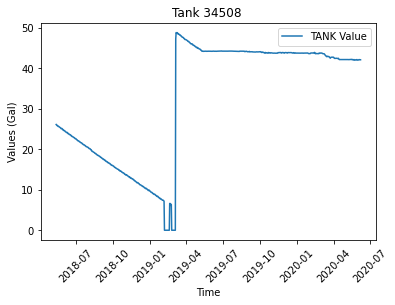

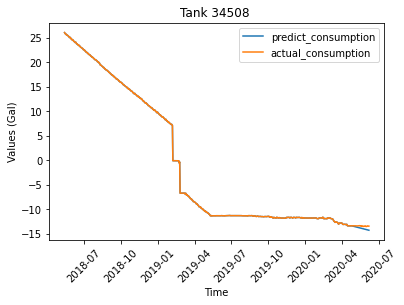

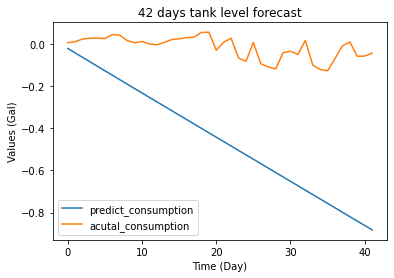

In [31]:
TANK_ID = 34508
CT_features_preds = CT_features.copy() 
CT_features_preds_moving = CT_features.copy() 

CT_features_preds[TANK_ID].iloc[nrow+window_size:] = predictions[:,4].flatten()
#CT_features_preds_moving[TANK_ID].iloc[nrow+window_size:] = preds_moving.flatten()

plt.plot(CT[TANK_ID], label = "TANK Value")
plt.title('Tank 34508 ')
plt.xlabel('Time')
plt.ylabel('Values (Gal)')
plt.xticks(rotation=45)
plt.legend()
plt.show()
plt.plot(CT_features_preds[TANK_ID].cumsum() + CT[TANK_ID].iloc[1],label= "predict_consumption" )
plt.plot(CT_features[TANK_ID].cumsum()+ CT[TANK_ID].iloc[1],label = "actual_consumption")
plt.title('Tank 34508 ')
plt.xlabel('Time')
plt.ylabel('Values (Gal)')
plt.xticks(rotation=45)
plt.legend()
plt.show()
plt.plot(predictions[:,4].cumsum(),label='predict_consumption')
plt.plot(CT_features.iloc[nrow+window_size:,4].to_numpy().cumsum(),label = 'acutal_consumption')
#plt.plot(actuals[:,4].cumsum(),label = 'actuals')

plt.legend()
plt.title('42 days tank level forecast')
plt.xlabel('Time (Day)')
plt.ylabel('Values (Gal)')
plt.show()

negative consumption : chemical is leaving the tanks<br>
separate tank value with consumptions

In [118]:
CT.iloc[:,43]

MeasurementDate
2018-05-13    72.907630
2018-05-14    72.460020
2018-05-15    71.517785
2018-05-16    70.540973
2018-05-17    69.531030
                ...    
2020-06-03     0.725531
2020-06-04    31.486241
2020-06-05    47.906408
2020-06-06    46.115715
2020-06-07    44.481446
Name: 228669, Length: 757, dtype: float64

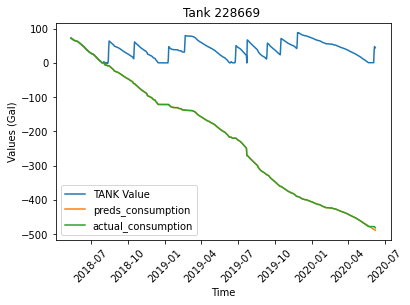

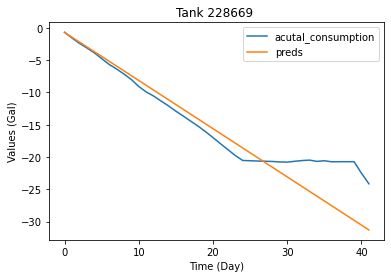

In [176]:
TANK_ID = 228669
CT_features_preds = CT_features.copy() 
#CT_features_preds_moving = CT_features.copy() 

CT_features_preds[TANK_ID].iloc[nrow+window_size:] = predictions[:,43].flatten()
#CT_features_preds_moving[TANK_ID].iloc[nrow+window_size:] = preds_moving.flatten()

plt.plot(CT[TANK_ID], label = "TANK Value")
plt.plot(CT_features_preds[TANK_ID].cumsum() + CT[TANK_ID].iloc[1],label= "preds_consumption" )
#plt.plot(CT_features_preds_moving[TANK_ID].cumsum()+ CT[TANK_ID].iloc[1],label = "preds_moving_consumption")
plt.plot(CT_features[TANK_ID].cumsum()+ CT[TANK_ID].iloc[1],label = "actual_consumption")
plt.title('Tank 228669 ')
plt.xlabel('Time')
plt.ylabel('Values (Gal)')
plt.xticks(rotation=45)
plt.legend()
plt.show()
plt.plot(CT_features.iloc[nrow+window_size:,43].to_numpy().cumsum(),label = 'acutal_consumption')
#plt.plot(actuals[:,43].cumsum(),label = 'actuals')
plt.plot(predictions[:,43].cumsum(),label='preds')
#plt.plot(preds_moving.cumsum(),label = 'preds_moving')
plt.legend()
plt.title('Tank 228669 ')
plt.xlabel('Time (Day)')
plt.ylabel('Values (Gal)')
plt.show()

In [121]:
CT.iloc[:,90]

MeasurementDate
2018-05-13      0.000000
2018-05-14      0.000000
2018-05-15      0.000000
2018-05-16      0.000000
2018-05-17      0.000000
                 ...    
2020-06-03    122.479997
2020-06-04    119.637802
2020-06-05    116.666462
2020-06-06    114.209138
2020-06-07    112.427413
Name: 517921, Length: 757, dtype: float64

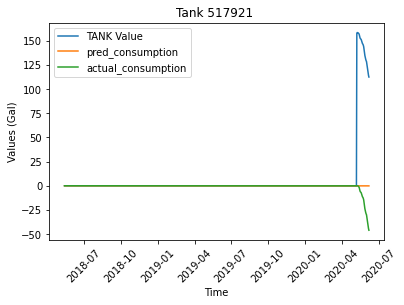

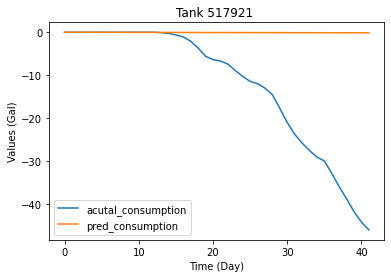

In [177]:
TANK_ID = 517921
CT_features_preds = CT_features.copy() 
#CT_features_preds_moving = CT_features.copy() 

CT_features_preds[TANK_ID].iloc[nrow+window_size:] = predictions[:,90].flatten()
#CT_features_preds_moving[TANK_ID].iloc[nrow+window_size:] = preds_moving.flatten()

plt.plot(CT[TANK_ID], label = "TANK Value")
plt.plot(CT_features_preds[TANK_ID].cumsum() + CT[TANK_ID].iloc[1],label= "pred_consumption" )
#plt.plot(CT_features_preds_moving[TANK_ID].cumsum()+ CT[TANK_ID].iloc[1],label = "preds_moving_consumption")
plt.plot(CT_features[TANK_ID].cumsum()+ CT[TANK_ID].iloc[1],label = "actual_consumption")
plt.title('Tank 517921 ')
plt.xlabel('Time')
plt.ylabel('Values (Gal)')
plt.xticks(rotation=45)
plt.legend()
plt.show()
plt.plot(CT_features.iloc[nrow+window_size:,90].to_numpy().cumsum(),label = 'acutal_consumption')
#plt.plot(actuals[:,43].cumsum(),label = 'actuals')
plt.plot(predictions[:,90].cumsum(),label='pred_consumption')
#plt.plot(preds_moving.cumsum(),label = 'preds_moving')
plt.legend()
plt.title('Tank 517921 ')
plt.xlabel('Time (Day)')
plt.ylabel('Values (Gal)')
plt.show()

#### Compared with the unscaled data

Data should be scaled and normalized

In [345]:
def process_single_tank(series,window_size):    

    series = pd.DataFrame(series)
    series_s = series.copy()
    for i in range(window_size):
        series = pd.concat([series,series_s.shift(-(i+1))],axis =1)    
    series.dropna(axis=0,inplace=True)
    nrow = round(0.8*series.shape[0])
    train = series.iloc[:nrow, :]
    test = series.iloc[nrow:,:]
    from sklearn.utils import shuffle
    train = shuffle(train)

    train_X = train.iloc[:,:-1]
    train_y = train.iloc[:,-1]
    test_X = test.iloc[:,:-1]
    test_y = test.iloc[:,-1]
    train_X = train_X.values
    train_y = train_y.to_numpy().reshape(-1,1)
    test_X = test_X.values
    test_y = test_y.to_numpy().reshape(-1,1)

    train_X = train_X.reshape(train_X.shape[0],train_X.shape[1],1)
    test_X = test_X.reshape(test_X.shape[0],test_X.shape[1],1)
    
    return train_X,train_y,test_X,test_y



In [346]:
window_size = 50
#train_X_all =np.empty((566,window_size,1))
#test_X_all = np.empty((141,window_size,1))
#train_y_all = np.empty((566,1))
#test_y_all = np.empty((141,1))
train_X_all = None

for column_name in CT_features: 
    series = CT_features[column_name].to_numpy().reshape(-1,1)
    train_X,train_y,test_X,test_y = process_single_tank(series,window_size)
    if train_X_all is None:
        train_X_all = train_X
        train_y_all = train_y
        test_X_all = test_X
        test_y_all = test_y
    else:
        train_X_all = np.concatenate([train_X_all, train_X], -1)
        test_X_all = np.concatenate([test_X_all, test_X], -1)
        train_y_all = np.concatenate([train_y_all, train_y], -1)
        test_y_all = np.concatenate([test_y_all, test_y], -1)
#train_y_all = np.transpose(train_y_all)
#test_y_all = np.transpose(test_y_all)

In [241]:
opt = Adam(lr=0.01, clipnorm=1.0)# gradient clipping to avoid exploding gradients
model = Sequential()
model.add(LSTM(256, return_sequences = True, input_shape = (50, 93)))
model.add(LSTM(128,input_shape = (50, 93)))
model.add(Dense(93,kernel_regularizer='l2'))# add L2 norm to regularize data, another way to avoid exploding gradients
model.compile(loss = 'mean_absolute_error', optimizer = opt)
model.fit(train_X_all, train_y_all, epochs = 3, batch_size = 20,validation_split=0.1)


Epoch 1/3
566/566 [==============================] - 4s 7ms/step - loss: 1.3420
Epoch 2/3
566/566 [==============================] - 3s 6ms/step - loss: 1.0912
Epoch 3/3
566/566 [==============================] - 3s 6ms/step - loss: 1.0779


In [413]:
# Doing a prediction on all the test data at once
preds = model.predict(test_X_all)
actuals = test_y_all

#### Metrics
absolute inventory difference 
metrics:
    what's a good forecast?
    good for 2 days/ entire period time 
    what' total amount will be used in the 42 days
    sign version(+/-) 
    mean absolute diviation is not a good idea 
    error at begin will be small but will grow in the end 
    good overall picture would be take look total amount of comsume/ predict or total of 
    predict total comsum / real total comsum 
    understand the metrics 
    
    
42 days: 21 day of tank is ordered to a tank is arrived 
  business requirement   2*maximum lead time long enough window to an order may happen 

logistics team 
that amount of time give them the ability to optimize the ordering process


having some summerary 

In [32]:
print(mean_absolute_error(test_y_all_21, CT_features.iloc[nrow+window_size:,]))

0.0


In [35]:
Y.shape

(42, 93)

In [34]:
Y = CT_features.iloc[nrow+window_size:,]
mse = mean_squared_error(Y,predictions)
mae =mean_absolute_error(Y,predictions)
abs_diff = abs(Y-predictions)
diff_CT = Y-predictions

In [36]:
total_abs_error = abs_diff.sum(axis=0) 
abs_total_error = abs(diff_CT.sum(axis=0))

In [37]:
abs_total_error

30850      0.128158
30851      5.374941
30852     57.978999
34507      1.423215
34508      0.838981
            ...    
387311     3.238532
516817     8.533242
517921    46.465443
544779     3.111010
544783     0.436465
Length: 93, dtype: float64

In [38]:
total_abs_error

30850      3.480842
30851      6.542981
30852     67.259987
34507      1.767609
34508      1.568949
            ...    
387311     4.099504
516817     8.805035
517921    46.465443
544779     3.125774
544783     0.811023
Length: 93, dtype: float64

Text(0, 0.5, 'total absolute error')

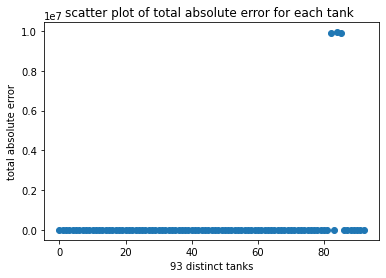

In [184]:
plt.scatter(x =np.arange(93), y = total_abs_error)
plt.title('scatter plot of total absolute error for each tank ')
plt.xlabel('93 distinct tanks')
plt.ylabel('total absolute error')


In [185]:
abs_diff.describe()

,30850,30851,30852,34507,34508,38357,40281,40283,40284,40886,...,387131,387175,387183,387309,387310,387311,516817,517921,544779,544783
count,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,...,42.000000,4.200000e+01,4.200000e+01,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000
mean,0.106051,0.144574,1.624614,0.031429,0.028629,0.957032,0.064171,0.126091,0.407030,5.411845,...,14.126914,2.365623e+05,2.356155e+05,0.006627,0.174559,0.071247,0.211886,1.093543,0.066082,0.020764
std,0.084893,0.073668,7.403657,0.024182,0.031982,0.725442,0.047737,0.077241,0.763231,24.005184,...,31.851093,1.533075e+06,1.526948e+06,0.000446,0.165642,0.142970,0.152682,1.106017,0.100368,0.028729
min,0.002315,0.019278,0.100506,0.000165,0.000379,0.023471,0.000978,0.006701,0.000958,0.020924,...,0.000991,1.465415e-03,4.417104e-03,0.004255,0.007364,0.000009,0.008281,0.001379,0.013292,0.002592
25%,0.048817,0.082748,0.190138,0.015874,0.007126,0.390851,0.026799,0.062349,0.007772,0.050412,...,0.001129,1.525576e-03,5.892675e-03,0.006721,0.039820,0.000556,0.037191,0.003239,0.014315,0.009268
50%,0.081604,0.138968,0.198563,0.029159,0.013613,0.851018,0.054095,0.117481,0.128689,0.130186,...,1.316978,1.884916e+00,6.018320e-01,0.006781,0.115983,0.000588,0.221713,0.852589,0.014338,0.009330
75%,0.159680,0.200614,0.248617,0.042753,0.038489,1.353084,0.084591,0.180568,0.436619,0.581731,...,8.780619,7.760222e+00,4.699959e+00,0.006784,0.294780,0.000614,0.306104,1.770641,0.031161,0.009622
max,0.344186,0.285254,48.322208,0.109360,0.112831,3.197177,0.203536,0.323704,3.825650,150.876226,...,146.021468,9.935468e+06,9.895755e+06,0.006784,0.540576,0.449605,0.580710,3.291978,0.348481,0.122090


Text(0, 0.5, 'mean of absolute difference')

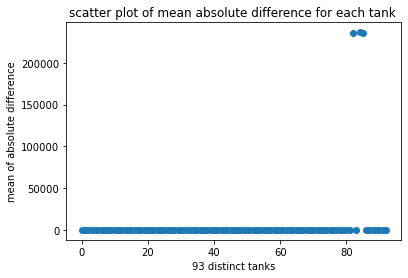

In [409]:
plt.scatter(x =np.arange(93), y = abs_diff.mean())
plt.title('scatter plot of mean absolute difference for each tank ')
plt.xlabel('93 distinct tanks')
plt.ylabel('mean of absolute difference')

Text(0, 0.5, 'mean of absolute difference')

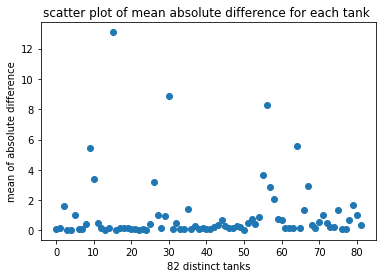

In [410]:
plt.scatter(x =np.arange(82), y = abs_diff.iloc[:,:82].mean())
plt.title('scatter plot of mean absolute difference for each tank ')
plt.xlabel('82 distinct tanks')
plt.ylabel('mean of absolute difference')

Text(0, 0.5, 'total absolute difference')

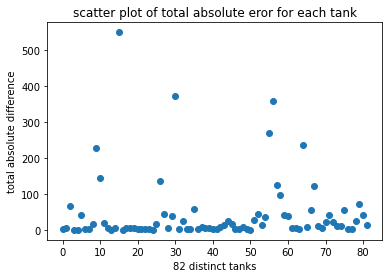

In [133]:
plt.scatter(x =np.arange(82), y = total_abs_error[:82])
plt.title('scatter plot of total absolute eror for each tank')
plt.xlabel('82 distinct tanks')
plt.ylabel('total absolute difference')

In [144]:
# why the outiles exits  
# include error over time 
print(np.median(total_abs_error), np.median(abs_total_error))

10.65936513184208 6.438048424133186


In [39]:
abs_total_error

30850      0.128158
30851      5.374941
30852     57.978999
34507      1.423215
34508      0.838981
            ...    
387311     3.238532
516817     8.533242
517921    46.465443
544779     3.111010
544783     0.436465
Length: 93, dtype: float64

In [40]:
abs_total_error =pd.DataFrame(abs_total_error)
abs_total_error.columns = ['abs_total_error']
CT_abs_total_error = abs_total_error.rename_axis('TANK_ID').reset_index()

In [41]:
CT_abs_total_error

,TANK_ID,abs_total_error
0,30850,0.128158
1,30851,5.374941
2,30852,57.978999
3,34507,1.423215
4,34508,0.838981
...,...,...
88,387311,3.238532
89,516817,8.533242
90,517921,46.465443
91,544779,3.111010


In [42]:
CT_abs_total_error.to_csv('C:/Users/wanru/OneDrive - Ecolab/Desktop/tlm_analysis/data/processed/08-13-20-CT-abs-total-error.csv',header=True,index=False)


**Gateway**

In [191]:
window_size = 21
train_X_all_21,test_X_all_21,train_y_all_21,test_y_all_21,nrow = process_all_tank(GT_features,window_size)

In [192]:
print(train_X_all_21.shape)
print(test_X_all_21.shape)
print(train_y_all_21.shape)
print(test_y_all_21.shape)
print(GT_features.shape)

(695, 21, 128)
(42, 21, 128)
(695, 128)
(42, 128)
(758, 128)


In [193]:
start = time.time()
opt = Adam(lr=0.001, clipnorm=1.0)# gradient clipping to avoid exploding gradients
GT_model_scaled_21_30batch = Sequential()
GT_model_scaled_21_30batch.add(LSTM(256, return_sequences = True, input_shape = (21, 128)))
GT_model_scaled_21_30batch.add(Dropout(0.5))
GT_model_scaled_21_30batch.add(LSTM(128,input_shape = (21, 128)))
GT_model_scaled_21_30batch.add(Dense(128,kernel_regularizer='l2'))# add L2 norm to regularize data, another way to avoid exploding gradients
GT_model_scaled_21_30batch.compile(loss = 'mean_absolute_error', optimizer = opt)
GT_model_scaled_result_21_30batch = GT_model_scaled_21_30batch.fit(train_X_all_21, train_y_all_21, epochs = 10, batch_size = 30,validation_split=0.1)
GT_model_scaled_21_30batch.save_weights('GT_LSTM_window21_30batch.h5')
print("> Compilation Time : ", time.time() - start)

Train on 625 samples, validate on 70 samples
Epoch 1/10
625/625 [==============================] - 2s 4ms/step - loss: 3.1729 - val_loss: 2.5875
Epoch 2/10
625/625 [==============================] - 2s 3ms/step - loss: 2.6498 - val_loss: 2.2000
Epoch 3/10
625/625 [==============================] - 2s 3ms/step - loss: 2.3255 - val_loss: 1.9926
Epoch 4/10
625/625 [==============================] - 2s 3ms/step - loss: 2.1391 - val_loss: 1.8441
Epoch 5/10
625/625 [==============================] - 2s 3ms/step - loss: 2.0213 - val_loss: 1.7463
Epoch 6/10
625/625 [==============================] - 2s 3ms/step - loss: 1.9417 - val_loss: 1.6842
Epoch 7/10
625/625 [==============================] - 2s 3ms/step - loss: 1.8892 - val_loss: 1.6451
Epoch 8/10
625/625 [==============================] - 2s 3ms/step - loss: 1.8538 - val_loss: 1.6108
Epoch 9/10
625/625 [==============================] - 2s 3ms/step - loss: 1.8311 - val_loss: 1.6021
Epoch 10/10
625/625 [==============================] - 

In [179]:
start = time.time()
opt = Adam(lr=0.001, clipnorm=1.0)# gradient clipping to avoid exploding gradients
GT_model_scaled_21_30batch = Sequential()
GT_model_scaled_21_30batch.add(LSTM(256, return_sequences = True, input_shape = (21, 128)))
GT_model_scaled_21_30batch.add(Dropout(0.5))
GT_model_scaled_21_30batch.add(LSTM(128,input_shape = (21, 128)))
GT_model_scaled_21_30batch.add(Dense(128,kernel_regularizer='l2'))# add L2 norm to regularize data, another way to avoid exploding gradients
GT_model_scaled_21_30batch.compile(loss = 'mean_absolute_error', optimizer = opt)
GT_model_scaled_result_21_40epoch = GT_model_scaled_21_30batch.fit(train_X_all_21, train_y_all_21, epochs = 40, batch_size = 30,validation_split=0.1)
print("> Compilation Time : ", time.time() - start)

Train on 625 samples, validate on 70 samples
Epoch 1/40
625/625 [==============================] - 6s 9ms/step - loss: 3.1814 - val_loss: 2.5971
Epoch 2/40
625/625 [==============================] - 3s 5ms/step - loss: 2.6554 - val_loss: 2.2108
Epoch 3/40
625/625 [==============================] - 3s 4ms/step - loss: 2.3340 - val_loss: 1.9922
Epoch 4/40
625/625 [==============================] - 3s 4ms/step - loss: 2.1440 - val_loss: 1.8531
Epoch 5/40
625/625 [==============================] - 3s 5ms/step - loss: 2.0244 - val_loss: 1.7538
Epoch 6/40
625/625 [==============================] - 3s 5ms/step - loss: 1.9449 - val_loss: 1.6950
Epoch 7/40
625/625 [==============================] - 3s 4ms/step - loss: 1.8915 - val_loss: 1.6423
Epoch 8/40
625/625 [==============================] - 3s 4ms/step - loss: 1.8562 - val_loss: 1.6173
Epoch 9/40
625/625 [==============================] - 3s 4ms/step - loss: 1.8337 - val_loss: 1.5978
Epoch 10/40
625/625 [==============================] - 

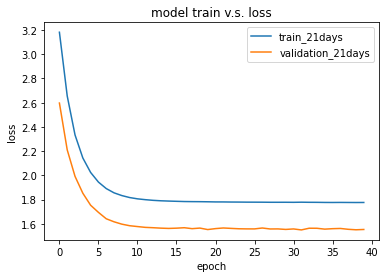

In [180]:
plt.plot(GT_model_scaled_result_21_40epoch.history['loss'])
plt.plot(GT_model_scaled_result_21_40epoch.history['val_loss'])

plt.title('model train v.s. loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_21days','validation_21days'], loc='upper right')

plt.show()

In [195]:
def moving_test_window_preds_GT(n_future_preds):

    ''' n_future_preds - Represents the number of future predictions we want to make
                         This coincides with the number of windows that we will move forward
                         on the test data
    '''
    preds_moving = []                                    # Use this to store the prediction made on each test window
    test_window = test_X_all_21[0,:]
    moving_test_window = test_window.reshape(1,test_window.shape[0],test_window.shape[1]) # (1,21,93)
    #moving_test_window = [test_window.tolist()]          # Creating the first test window
    #moving_test_window = np.array(moving_test_window)    # Making it an numpy array
    
    for i in range(n_future_preds):
        preds_one_step = GT_model_scaled_21_30batch.predict(moving_test_window) # Note that this is already a scaled prediction so no need to rescale this
        preds_moving.append(preds_one_step[0,:]) # get the value from the numpy 2D array and append to predictions
        preds_one_step = preds_one_step.reshape(1,preds_one_step.shape[0],preds_one_step.shape[1]) # Reshaping the prediction to 3D array for concatenation with moving test window
        moving_test_window = np.concatenate((moving_test_window[:,1:,:], preds_one_step), axis=1) # This is the new moving test window, where the first element from the window has been removed and the prediction has been appended to the end
        
    #preds_moving = scaler.inverse_transform(np.array(preds_moving).reshape(-1,1))
    
    return np.array(preds_moving)

In [196]:
GT_preds = GT_model_scaled_21_30batch.predict(test_X_all_21)
GT_actuals = test_y_all_21
GT_predictions = moving_test_window_preds_GT(42)

In [197]:
GT_Y = GT_features.iloc[nrow+window_size:,]
GT_mse = mean_squared_error(GT_Y,GT_predictions)
GT_mae =mean_absolute_error(GT_Y,GT_predictions)
GT_abs_diff = abs(GT_Y-GT_predictions)
GT_diff = GT_Y-GT_predictions
GT_total_abs_error = GT_abs_diff.sum(axis=0) 
GT_abs_total_error = abs(GT_diff.sum(axis=0))

In [198]:
GT_diff =pd.DataFrame(GT_diff.T)
GT_diff = GT_diff.rename_axis('TANK_ID').reset_index()
GT_diff

MeasurementDate,TANK_ID,2020-04-28 00:00:00,2020-04-29 00:00:00,2020-04-30 00:00:00,2020-05-01 00:00:00,2020-05-02 00:00:00,2020-05-03 00:00:00,2020-05-04 00:00:00,2020-05-05 00:00:00,2020-05-06 00:00:00,...,2020-05-30 00:00:00,2020-05-31 00:00:00,2020-06-01 00:00:00,2020-06-02 00:00:00,2020-06-03 00:00:00,2020-06-04 00:00:00,2020-06-05 00:00:00,2020-06-06 00:00:00,2020-06-07 00:00:00,2020-06-08 00:00:00
0,1282,-8.723209,-1.362381,2.558274,2.114485,2.484297,2.743142,-0.215706,-6.170330,-8.167549,...,2.446815,2.039980,-2.065355,2.557770,2.557770,-5.374707,-2.269576,2.483800,2.520785,-285.141226
1,4730,-0.253639,-0.197429,-0.050662,-0.220005,0.039700,-0.095774,-0.005441,0.028437,-0.231243,...,0.028566,0.141473,-0.022755,0.158922,-0.524675,-0.118212,-0.118212,-0.036098,0.161956,-57.004144
2,4731,-0.434228,-0.479186,0.164371,0.040168,0.288552,0.074018,0.322401,0.277231,0.051413,...,0.254662,0.356278,-0.050185,-0.185673,-0.084057,0.209499,0.220790,0.302904,0.325217,-29.326432
3,4732,0.016886,0.010655,0.089733,0.146187,-0.000603,-0.057068,0.213898,0.202600,-0.079672,...,0.146043,0.044427,0.138679,0.017919,0.021846,0.067008,0.100880,0.101907,0.007074,-53.263046
4,4733,-0.025056,-0.058913,0.155640,-0.318545,-0.013684,0.042778,0.054073,0.347631,-0.070121,...,0.178273,0.212145,0.207726,-0.088284,-0.239481,0.212145,0.065366,0.131057,0.090491,-20.667444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,375013,0.003694,-0.504103,-0.594369,-0.345978,0.015306,-0.136888,-0.611596,-0.323448,0.455598,...,-0.210682,-0.142938,-0.233263,-0.075194,-0.109066,-0.210682,-0.413913,-0.628435,-0.199391,-89.619262
124,375414,-0.004629,-0.004633,-0.004611,-0.004604,-0.004601,-0.004600,-0.004599,-0.004599,-0.004600,...,-0.130407,-0.062693,-0.333547,-0.178774,-0.372240,-0.236814,-0.004653,-0.198120,-0.033673,-60.935149
125,386783,-0.159800,-0.012966,0.088667,-0.125846,0.145134,-0.182290,-0.182287,0.280631,-0.058087,...,-0.091951,-0.137114,0.054827,-0.204858,0.066117,0.077408,-0.046789,-0.170986,-0.216148,-0.888694
126,387170,-0.326449,-0.026513,-0.026572,-0.229762,-0.162087,-0.336236,-0.297562,-0.336268,-0.345949,...,-0.336263,-0.665157,-0.713524,-0.104103,-0.220183,-0.094430,-0.055736,-0.258877,-0.171817,-84.014007


In [200]:
GT_abs_total_error =pd.DataFrame(GT_abs_total_error)
GT_abs_total_error.columns = ['abs_total_error']
GT_abs_total_error = GT_abs_total_error.rename_axis('TANK_ID').reset_index()

In [210]:
CT_abs_total_error

,TANK_ID,abs_total_error
0,30850,3.564712
1,30851,4.603881
2,30852,56.127638
3,34507,0.491354
4,34508,0.136786
...,...,...
88,387311,1.978143
89,516817,8.699191
90,517921,45.857162
91,544779,2.743559


In [202]:
GT_abs_total_error.to_csv('C:/Users/wanru/OneDrive - Ecolab/Desktop/tlm_analysis/data/processed/08-11-20-GT-abs-total-error.csv',index=False)


In [42]:
GT_diff.to_csv('C:/Users/wanru/OneDrive - Ecolab/Desktop/tlm_analysis/data/processed/08-06-20-GT-daily-difference.csv',index=False)
diff.to_csv('C:/Users/wanru/OneDrive - Ecolab/Desktop/tlm_analysis/data/processed/08-06-20-CT-daily-difference.csv',index=False)
